In [ ]:
!nvidia-smi

Tue Jul 27 06:37:50 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import zipfile
import cv2
from skimage import io
import tensorflow as tf
from tensorflow.python.keras import Sequential
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from IPython.display import display
from tensorflow.keras import backend as K
from sklearn.preprocessing import StandardScaler, normalize
import os
import glob
import random
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# data containing path to Brain MRI and their corresponding mask
brain_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Dataset/Segmentation_Brain_Tumor_Data/lgg-mri-segmentation/kaggle_3m/data.csv')
brain_df.head()

,Patient,RNASeqCluster,MethylationCluster,miRNACluster,CNCluster,RPPACluster,OncosignCluster,COCCluster,histological_type,neoplasm_histologic_grade,tumor_tissue_site,laterality,tumor_location,gender,age_at_initial_pathologic,race,ethnicity,death01
0,TCGA_CS_4941,2.0,4.0,2,2.0,NaN,3.0,2,1.0,2.0,1.0,3.0,2.0,2.0,67.0,3.0,2.0,1.0
1,TCGA_CS_4942,1.0,5.0,2,1.0,1.0,2.0,1,1.0,2.0,1.0,3.0,2.0,1.0,44.0,2.0,NaN,1.0
2,TCGA_CS_4943,1.0,5.0,2,1.0,2.0,2.0,1,1.0,2.0,1.0,1.0,2.0,2.0,37.0,3.0,NaN,0.0
3,TCGA_CS_4944,NaN,5.0,2,1.0,2.0,1.0,1,1.0,1.0,1.0,3.0,6.0,2.0,50.0,3.0,NaN,0.0
4,TCGA_CS_5393,4.0,5.0,2,1.0,2.0,3.0,1,1.0,2.0,1.0,1.0,6.0,2.0,39.0,3.0,NaN,0.0


In [ ]:
brain_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110 entries, 0 to 109
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Patient                    110 non-null    object 
 1   RNASeqCluster              92 non-null     float64
 2   MethylationCluster         109 non-null    float64
 3   miRNACluster               110 non-null    int64  
 4   CNCluster                  108 non-null    float64
 5   RPPACluster                98 non-null     float64
 6   OncosignCluster            105 non-null    float64
 7   COCCluster                 110 non-null    int64  
 8   histological_type          109 non-null    float64
 9   neoplasm_histologic_grade  109 non-null    float64
 10  tumor_tissue_site          109 non-null    float64
 11  laterality                 109 non-null    float64
 12  tumor_location             109 non-null    float64
 13  gender                     109 non-null    float64

In [ ]:
data_map = []
for sub_dir_path in glob.glob("/content/drive/MyDrive/Colab Notebooks/Dataset/Segmentation_Brain_Tumor_Data/lgg-mri-segmentation/kaggle_3m/"+"*"):
    try:
        dir_name = sub_dir_path.split('/')[-1]
        for filename in os.listdir(sub_dir_path):
            image_path = sub_dir_path+"/"+filename
            data_map.extend([dir_name, image_path])
    except Exception as e:
        print(e)

[Errno 20] Not a directory: '/content/drive/MyDrive/Colab Notebooks/Dataset/Segmentation_Brain_Tumor_Data/lgg-mri-segmentation/kaggle_3m/README.md'
[Errno 20] Not a directory: '/content/drive/MyDrive/Colab Notebooks/Dataset/Segmentation_Brain_Tumor_Data/lgg-mri-segmentation/kaggle_3m/data.csv'


In [ ]:
df = pd.DataFrame({"patient_id": data_map[::2], "path": data_map[1::2]})
df.head()

,patient_id,path
0,TCGA_HT_A61B_19991127,/content/drive/MyDrive/Colab Notebooks/Dataset...
1,TCGA_HT_A61B_19991127,/content/drive/MyDrive/Colab Notebooks/Dataset...
2,TCGA_HT_A61B_19991127,/content/drive/MyDrive/Colab Notebooks/Dataset...
3,TCGA_HT_A61B_19991127,/content/drive/MyDrive/Colab Notebooks/Dataset...
4,TCGA_HT_A61B_19991127,/content/drive/MyDrive/Colab Notebooks/Dataset...


In [ ]:
df_imgs = df[~df['path'].str.contains("mask")]
df_masks = df[df['path'].str.contains("mask")]

BASE_LEN = 152
END_IMG_LEN = 4
END_MASK_LEN = 9


imgs = sorted(df_imgs["path"].values, key=lambda x: int(x[BASE_LEN:-END_IMG_LEN]))
masks = sorted(df_masks["path"].values, key=lambda x: int(x[BASE_LEN:-END_MASK_LEN]))


# Sorting check
idx = random.randint(0, len(imgs)-1)
print("Path to the Image:", imgs[idx], "\nPath to the Mask:", masks[idx])

Path to the Image: /content/drive/MyDrive/Colab Notebooks/Dataset/Segmentation_Brain_Tumor_Data/lgg-mri-segmentation/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_23.tif 
Path to the Mask: /content/drive/MyDrive/Colab Notebooks/Dataset/Segmentation_Brain_Tumor_Data/lgg-mri-segmentation/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_23_mask.tif


In [ ]:
# Final dataframe
brain_df = pd.DataFrame({"patient_id": df_imgs.patient_id.values,
                         "image_path": imgs,
                         "mask_path": masks
                        })

def pos_neg_diagnosis(mask_path):
    value = np.max(cv2.imread(mask_path))
    if value > 0 : 
        return 1
    else:
        return 0
    
brain_df['mask'] = brain_df['mask_path'].apply(lambda x: pos_neg_diagnosis(x))
brain_df.head()

,patient_id,image_path,mask_path,mask
0,TCGA_HT_A61B_19991127,/content/drive/MyDrive/Colab Notebooks/Dataset...,/content/drive/MyDrive/Colab Notebooks/Dataset...,0
1,TCGA_HT_A61B_19991127,/content/drive/MyDrive/Colab Notebooks/Dataset...,/content/drive/MyDrive/Colab Notebooks/Dataset...,0
2,TCGA_HT_A61B_19991127,/content/drive/MyDrive/Colab Notebooks/Dataset...,/content/drive/MyDrive/Colab Notebooks/Dataset...,0
3,TCGA_HT_A61B_19991127,/content/drive/MyDrive/Colab Notebooks/Dataset...,/content/drive/MyDrive/Colab Notebooks/Dataset...,0
4,TCGA_HT_A61B_19991127,/content/drive/MyDrive/Colab Notebooks/Dataset...,/content/drive/MyDrive/Colab Notebooks/Dataset...,0


In [ ]:
brain_df_mask = brain_df[brain_df['mask']==1]
brain_df_mask.shape

(1373, 4)

In [ ]:
from sklearn.model_selection import train_test_split
# creating test, train and val sets
X_train, X_val = train_test_split(brain_df_mask, test_size=0.15)
X_test, X_val = train_test_split(X_val, test_size=0.5)
print("Train size is ", len(X_train), "valid size is ", len(X_val),"test size is",len(X_test))

train_ids = list(X_train.image_path)
train_mask = list(X_train.mask_path)

val_ids = list(X_val.image_path)
val_mask= list(X_val.mask_path)

Train size is  1167 valid size is  103 test size is 103


In [ ]:
image_size = 256
batch_size = 32

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import cv2
import tensorflow as tf
import os
from skimage import io
from PIL import Image
from tensorflow.keras import backend as K 

#creating a custom datagenerator

class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, ids , mask, image_dir = ' ', batch_size = 32, img_h = 256, img_w = 256, shuffle = True):

        self.ids = ids
        self.mask = mask
        self.image_dir = image_dir
        self.batch_size = batch_size
        self.img_h = img_h
        self.img_w = img_w
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Get the number of batches per epoch'

        return int(np.floor(len(self.ids))/self.batch_size)

    def __getitem__(self, index):
        'Generate a batch of data'

        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        list_ids = [self.ids[i] for i in indexes]

        list_mask = [self.mask[i] for i in indexes]

        X, y = self.__data_generation(list_ids, list_mask)

        return X, y

    def on_epoch_end(self):
        'Used fror updating the indices after each epoch, once at the beginning as well as at the end of each epoch'
        self.indexes = np.arange(len(self.ids))

        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_ids, list_mask):
        'generate the data corresponding the indexex in a given batch of images'

        X = np.empty((self.batch_size, self.img_h, self.img_w, 3))
        y = np.empty((self.batch_size, self.img_h, self.img_w, 1))

        for i in range(len(list_ids)):
            img_path = str(list_ids[i])
            mask_path = str(list_mask[i])

            img = io.imread(img_path)
            mask = io.imread(mask_path)

            img = cv2.resize(img, (self.img_h, self.img_w))
            img = np.array(img, dtype=np.float64)
            mask = cv2.resize(mask, (self.img_h, self.img_w))
            mask = np.array(mask, dtype=np.float64)

            img -= img.mean()
            img /= img.std()

            mask -= mask.mean()
            mask /= mask.std()

            X[i,] = img
            y[i,] = np.expand_dims(mask, axis = 2)

        y = (y>0).astype(int)

        return X, y

In [ ]:
train_data = DataGenerator(train_ids, train_mask)
val_data = DataGenerator(val_ids, val_mask)

In [ ]:
len(train_data)

36

In [ ]:
from tensorflow import keras

In [ ]:
def bn_act(x, act=True):
    x = keras.layers.BatchNormalization()(x)
    if act == True:
        x = keras.layers.Activation("relu")(x)
    return x

def conv_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    conv = bn_act(x)
    conv = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides)(conv)
    conv = keras.layers.Dropout(0.3)(conv)
    return conv

def stem(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    conv = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides)(x)
    conv = conv_block(conv, filters, kernel_size=kernel_size, padding=padding, strides=strides)
    
    shortcut = keras.layers.Conv2D(filters, kernel_size=(1, 1), padding=padding, strides=strides)(x)
    shortcut = bn_act(shortcut, act=False)
    
    output = keras.layers.Add()([conv, shortcut])
    return output

def residual_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    res = conv_block(x, filters, kernel_size=kernel_size, padding=padding, strides=strides)
    res = conv_block(res, filters, kernel_size=kernel_size, padding=padding, strides=1)
    
    shortcut = keras.layers.Conv2D(filters, kernel_size=(1, 1), padding=padding, strides=strides)(x)
    shortcut = bn_act(shortcut, act=False)
    
    output = keras.layers.Add()([shortcut, res])
    return output

def upsample_concat_block(x, xskip):
    u = keras.layers.UpSampling2D((2, 2))(x)
    c = keras.layers.Concatenate()([u, xskip])
    return c

In [ ]:
def ResUNet():
    f = [16, 32, 64, 128, 256]
    inputs = keras.layers.Input((image_size, image_size, 3))
    
    ## Encoder
    e0 = inputs
    e1 = stem(e0, f[0])
    e2 = residual_block(e1, f[1], strides=2)
    e3 = residual_block(e2, f[2], strides=2)
    e4 = residual_block(e3, f[3], strides=2)
    e5 = residual_block(e4, f[4], strides=2)
    
    ## Bridge
    b0 = conv_block(e5, f[4], strides=1)
    b1 = conv_block(b0, f[4], strides=1)
    
    ## Decoder
    u1 = upsample_concat_block(b1, e4)
    d1 = residual_block(u1, f[4])
    
    u2 = upsample_concat_block(d1, e3)
    d2 = residual_block(u2, f[3])
    
    u3 = upsample_concat_block(d2, e2)
    d3 = residual_block(u3, f[2])
    
    u4 = upsample_concat_block(d3, e1)
    d4 = residual_block(u4, f[1])
    
    outputs = keras.layers.Conv2D(1, (1, 1), padding="same", activation="sigmoid")(d4)
    model = keras.models.Model(inputs, outputs)
    return model

In [ ]:
print(len(train_data))
print(len(val_data))

36
3


In [ ]:
from keras.losses import binary_crossentropy

epsilon = 1e-5
smooth = 1

def tversky(y_true, y_pred):
    y_true_pos = K.flatten(y_true)
    y_pred_pos = K.flatten(y_pred)
    true_pos = K.sum(y_true_pos * y_pred_pos)
    false_neg = K.sum(y_true_pos * (1-y_pred_pos))
    false_pos = K.sum((1-y_true_pos)*y_pred_pos)
    alpha = 0.7
    return (true_pos + smooth)/(true_pos + alpha*false_neg + (1-alpha)*false_pos + smooth)

def focal_tversky(y_true,y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    
    pt_1 = tversky(y_true, y_pred)
    gamma = 0.75
    return K.pow((1-pt_1), gamma)

def tversky_loss(y_true, y_pred):
    return 1 - tversky(y_true,y_pred)

def dice_coef(y_true, y_pred):
    return (2. * K.sum(y_true * y_pred)) / (K.sum(y_true) + K.sum(y_pred))

def IoU(pred, targs):
    pred = (pred>0).float()
    intersection = (pred*targs).sum()
    return intersection / ((pred+targs).sum() - intersection + 1.0)

In [ ]:
model = ResUNet()

In [ ]:

adam = tf.keras.optimizers.Adam(lr = 0.05, epsilon = 0.1)
model.compile(optimizer = adam, 
                  loss = focal_tversky, 
                  metrics = [tversky, dice_coef]
                 )
#callbacks
earlystopping = EarlyStopping(monitor='val_loss',
                              mode='min', 
                              verbose=1, 
                              patience=20
                             )
# save the best model with lower validation loss
checkpointer = ModelCheckpoint(filepath="ResUNet-segModel-weights.hdf5", 
                               verbose=1, 
                               save_best_only=True
                              )
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              mode='min',
                              verbose=1,
                              patience=10,
                              min_delta=0.0001,
                              factor=0.2
                             )

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 16) 64          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 256, 256, 16) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [ ]:
hist = model.fit(train_data, 
                  epochs = 100, 
                  validation_data = val_data,
                  callbacks = [checkpointer, earlystopping, reduce_lr]
                 )

Epoch 1/100
36/36 [==============================] - 491s 12s/step - loss: 0.8376 - tversky: 0.2095 - dice_coef: 0.1412 - val_loss: 0.8214 - val_tversky: 0.2308 - val_dice_coef: 0.1535

Epoch 00001: val_loss improved from inf to 0.82137, saving model to ResUNet-segModel-weights.hdf5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/100
36/36 [==============================] - 33s 906ms/step - loss: 0.5564 - tversky: 0.5404 - dice_coef: 0.4834 - val_loss: 0.6340 - val_tversky: 0.4540 - val_dice_coef: 0.3504

Epoch 00002: val_loss improved from 0.82137 to 0.63405, saving model to ResUNet-segModel-weights.hdf5
Epoch 3/100
36/36 [==============================] - 31s 862ms/step - loss: 0.4855 - tversky: 0.6177 - dice_coef: 0.5750 - val_loss: 0.5528 - val_tversky: 0.5459 - val_dice_coef: 0.5341

Epoch 00003: val_loss improved from 0.63405 to 0.55279, saving model to ResUNet-segModel-weights.hdf5
Epoch 4/100
36/36 [==============================] - 32s 872ms/step - loss: 0.4403 - tversky: 0.6636 - dice_coef: 0.6307 - val_loss: 0.3826 - val_tversky: 0.7219 - val_dice_coef: 0.6932

Epoch 00004: val_loss improved from 0.55279 to 0.38257, saving model to ResUNet-segModel-weights.hdf5
Epoch 5/100
36/36 [==============================] - 31s 864ms/step - loss: 0.3881 - tversky: 0.7160 - dice_coef: 0.6933 - val_loss: 

In [ ]:
model_json = model_seg.to_json()
with open("ResUNet-model.json","w") as json_file:
    json_file.write(model_json)

In [ ]:
test_ids = list(X_test.image_path)
test_mask = list(X_test.mask_path)
test_data = DataGenerator(test_ids, test_mask)
_, tv, dc = model.evaluate(test_data)
print("Segmentation tversky is {:.2f}%".format(tv*100))
print("Segmentation tversky is {:.2f}%".format(dc*100))

3/3 [==============================] - 28s 14s/step - loss: 0.1696 - tversky: 0.9059 - dice_coef: 0.8658
Segmentation tversky is 90.59%
Segmentation tversky is 86.58%


In [ ]:
# plt.figure(figsize=(12,5))
# plt.subplot(1,2,1)
plt.plot(hist.history['loss']);
plt.plot(hist.history['val_loss']);
plt.title("SEG Model focal tversky Loss");
plt.ylabel("focal tversky loss");
plt.xlabel("Epochs");
plt.legend(['train', 'val']);

# plt.subplot(1,2,2)


In [ ]:
plt.plot(hist.history['tversky']);
plt.plot(hist.history['val_tversky']);
plt.title("SEG Model tversky score");
plt.ylabel("tversky Accuracy");
plt.xlabel("Epochs");
plt.legend(['train', 'val']);

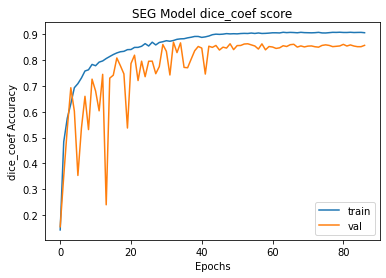

In [ ]:
plt.plot(hist.history['dice_coef']);
plt.plot(hist.history['val_dice_coef']);
plt.title("SEG Model dice_coef score");
plt.ylabel("dice_coef Accuracy");
plt.xlabel("Epochs");
plt.legend(['train', 'val']);

In [ ]:
from tensorflow.keras.models import load_model
model_seg.save('Segmentation.h5')

Testing the model performance

In [ ]:
labels = np.load('/content/drive/MyDrive/Colab Notebooks/Dataset/labels.npy')

In [ ]:
classifier_model = load_model('/content/drive/MyDrive/Colab Notebooks/Dataset/vgg16_classifier.h5')

In [ ]:
custom_obj = {'loss': focal_tversky}
model_seg = load_model('/content/drive/MyDrive/Colab Notebooks/Dataset/brain_tumor_segmentation_acc_91.h5', compile=False)

In [ ]:
i = '/content/drive/MyDrive/Colab Notebooks/Dataset/Tumor_Images/content/Tumor_Images/22.png'

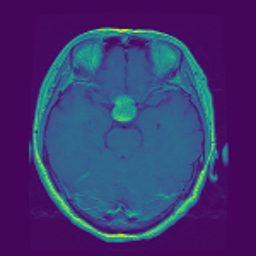

In [ ]:

import PIL
image = cv2.imread(i)
d = (256,256)
image = cv2.resize(image, d)
cv2.imwrite('image.jpg', image)
PIL.Image.open(i)

In [ ]:
import cv2
import numpy as np
img = cv2.imread(i)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img2 = np.zeros_like(img)
img2[:,:,0] = gray
img2[:,:,1] = gray
img2[:,:,2] = gray
cv2.imwrite('1.jpg', img2)

True

In [ ]:
temp = cv2.imread('/content/1.jpg')
print(temp.shape)

(256, 256, 3)


In [ ]:
image_id = []
has_mask = []
mask = []

In [ ]:
i = '/content/1.jpg'

In [ ]:
IMG_SIZE = 224
img_array = cv2.imread(i)
new_array = cv2.resize(img_array,(IMG_SIZE,IMG_SIZE), 3) 
new_array = np.array(new_array).reshape(-1,IMG_SIZE, IMG_SIZE)
print(new_array.shape)
new_array = new_array/255.0  
new_array = new_array.reshape(-1,224, 224, 3)

(3, 224, 224)


In [ ]:
pred = classifier_model.predict(new_array)

In [ ]:
pred = np.argmax(pred, axis=1)
if pred == 1:
    print("meningioma")
elif pred == 2:
    print("glioma")
else:
    print("pituitary")

meningioma


In [ ]:
labels[1]

1

In [ ]:
img = io.imread(i)
#normalizing
img = img *1./255.
#reshaping
img = cv2.resize(img, (256,256))
# converting img into array
img = np.array(img, dtype=np.float64)
#reshaping the image from 256,256,3 to 1,256,256,3
print(img.shape)
img = np.reshape(img, (1,256,256,3))
        
#         #making prediction for tumor in image
# is_defect = model.predict(img)
        
#         #if tumour is not present we append the details of the image to the list
# if np.argmax(is_defect)==0:
#         image_id.append(i)
#         has_mask.append(0)
#         mask.append('No mask :)')
#         continue
        
        #Creating a empty array of shape 1,256,256,1
X = np.empty((1,256,256,3))
        # read the image
img = io.imread(i)
        #resizing the image and coverting them to array of type float64
img = cv2.resize(img, (256,256))
img = np.array(img, dtype=np.float64)
        
        # standardising the image
img -= img.mean()
img /= img.std()
        #converting the shape of image from 256,256,3 to 1,256,256,3
X[0,] = img
        
        #make prediction of mask
predict = model_seg.predict(X)
        
        # if sum of predicted mask is 0 then there is not tumour
if predict.round().astype(int).sum()==0:
        image_id.append(i)
        has_mask.append(0)
        mask.append('No mask :)')
else:
        #if the sum of pixel values are more than 0, then there is tumour
        image_id.append(i)
        has_mask.append(1)
        mask.append(predict)

print(img.shape)

(256, 256, 3)
(256, 256, 3)


In [ ]:
has_mask

[1]

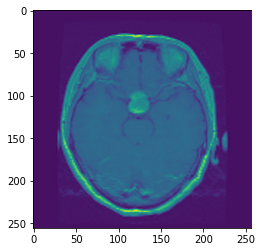

In [ ]:
import matplotlib.pyplot as plt

img = io.imread(image_id[0])
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(img)

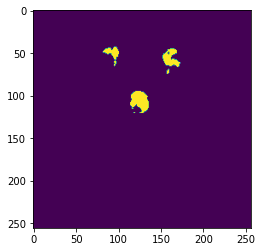

In [ ]:
pred = np.array(mask[0]).squeeze().round()
plt.imshow(pred)

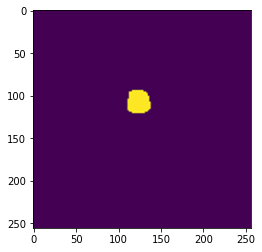

In [ ]:
# original mask image 
mask = io.imread('/content/drive/MyDrive/Colab Notebooks/Dataset/Mask_Images/content/Mask_Images/22.png')
plt.imshow(mask)

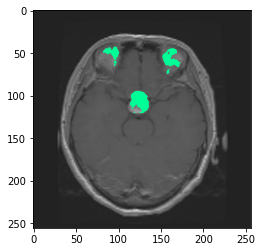

In [ ]:
dim = (256, 256)
img = cv2.resize(img, dim)
img+3
img_ = io.imread(image_id[0])
dim = (256, 256)
img_ = cv2.resize(img_, dim)
img_ = cv2.cvtColor(img_, cv2.COLOR_BGR2RGB)
img_[pred==1] = (0,255,150)
plt.imshow(img_)